In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import task_complexity
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class AddGaussianNoise(object):
    def __init__(self, mean = 0, std = 1.):
        self.std = std
        self.mean = mean
    
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size())*self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [3]:
class Net_CIFAR10(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x

In [4]:
criterion = nn.CrossEntropyLoss(reduction = "none")

In [5]:
noise_levels = np.logspace(1e-6, 1e0, 10)
mi_values = []
for noise_level in noise_levels:
    print(f"Noise Level: {noise_level}")
    transform = transforms.Compose([
        transforms.ToTensor(),
        AddGaussianNoise(0., noise_level),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    target_transform_cifar10 = transforms.Compose([
        lambda x: torch.tensor(x),
        lambda x: F.one_hot(x, num_classes = 10)
        ])
    
    batch_size = 16

    trainset_cifar10 = CIFAR10(root = '../example_data/', train = True, transform = transform, target_transform = target_transform_cifar10, download = True)
    trainloader_cifar10 = torch.utils.data.DataLoader(trainset_cifar10, batch_size = batch_size, shuffle = True, num_workers = 2)
    
    example_set = next(iter(trainloader_cifar10))[0]

    mi_score = task_complexity.compute_complexity(Net_CIFAR10, 10, trainloader_cifar10, criterion, n_bins = 100)
    print(f"MI Score: {mi_score}")
    mi_values.append(mi_score)

Noise Level: 0.001
Files already downloaded and verified


/tmp/ipykernel_23060/1150912648.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


MI Score: 0.016311700209284297
Noise Level: 0.112
Files already downloaded and verified
MI Score: 0.011080062493128207
Noise Level: 0.223
Files already downloaded and verified
MI Score: 0.01492359819080713
Noise Level: 0.334
Files already downloaded and verified
MI Score: 0.006926550603765236
Noise Level: 0.445
Files already downloaded and verified
MI Score: 0.011051890158844113
Noise Level: 0.556
Files already downloaded and verified
MI Score: 0.0049090070697381805
Noise Level: 0.667
Files already downloaded and verified
MI Score: 0.006598993291383248
Noise Level: 0.778
Files already downloaded and verified
MI Score: 0.01001170978694077
Noise Level: 0.889
Files already downloaded and verified
MI Score: 0.008072772260546035
Noise Level: 1.0
Files already downloaded and verified
MI Score: 0.005562780257656108


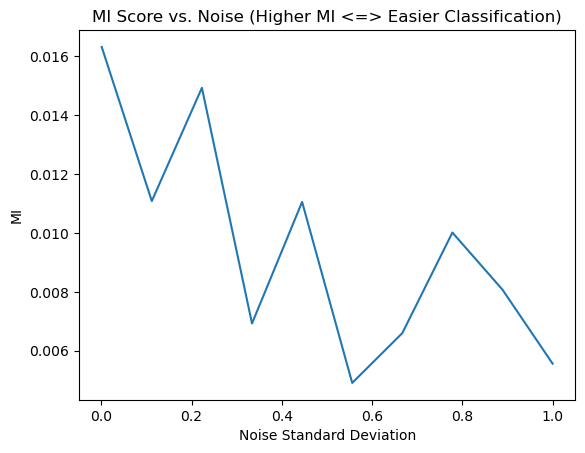

In [7]:
plt.plot(noise_levels, mi_values)
plt.title("MI Score vs. Noise (Higher MI <=> Easier Classification)")
plt.xlabel("Noise Standard Deviation")
plt.ylabel("MI")
plt.show()